# Regree of rate control

Here are some tutorials on the degree of rate control as implemented in
overreact.

## Langmuir-Hinshelwood mechanism

Here we try to reproduce the analysis on the Langmuir-Hinshelwood mechanism of
<https://pubs.acs.org/doi/full/10.1021/acscatal.7b00115>.

In [1]:
from overreact import core, api, rates, simulate

scheme = core.parse_reactions("""
A + * <=> A*  # fast to equilibrium
B + * <=> B*  # fast to equilibrium
A* + B* -> AB*‡ -> AB* + *  # RDS
AB* <=> AB + *  # fast to equilibrium
""")
scheme.compounds

('A', '*', 'A*', 'B', 'B*', 'AB*‡', 'AB*', 'AB')

In [2]:
scheme.reactions

('A + * -> A*',
 'A* -> A + *',
 'B + * -> B*',
 'B* -> B + *',
 'A* + B* -> AB* + *',
 'AB* -> AB + *',
 'AB + * -> AB*')

where ``*`` denotes a free surface site.

In [3]:
import numpy as np
from scipy.misc import derivative
from overreact import constants

k = rates.eyring(constants.kcal * api.get_delta(scheme.B, [0, 0, -2.5, 0, -2.5, 15.0, 0.0, -2.5]))
k

array([4.22449484e+14, 6.21243799e+12, 4.22449484e+14, 6.21243799e+12,
       1.35881500e-02, 4.22449484e+14, 6.21243799e+12])

In [4]:
dydt = simulate.get_dydt(scheme, k)

Now the graph:

Text(0, 0.5, 'Concentration (M)')

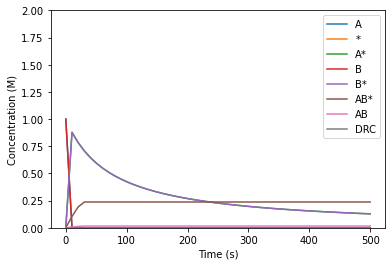

In [5]:
import matplotlib.pyplot as plt

y0 = [1., 1000., 0, 1., 0., 0., 0., 0.]
y, r = simulate.get_y(dydt, y0, [0.0, 30 * 60.0])
t = np.linspace(y.t_min, 500.0)

for i, compound in enumerate(scheme.compounds):
   if not compound.endswith("‡"):
       plt.plot(t, y(t)[i], label=compound)
drc = [derivative(lambda k: simulate.get_dydt(scheme, k)(0.0, y)[-1], k, 1e-4) for y in y(t).T]
plt.plot(t, drc, label="DRC")
plt.legend()
plt.xlabel("Time (s)")
plt.ylim(0, 2)
plt.ylabel("Concentration (M)")

A one minute simulation of the Langmuir-Hinshelwood mechanism.

## Another example

Calculate the degree of rate control for a reaction system.

In [6]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from overreact import api
from overreact import datasets

sns.set(style="white", palette="colorblind")

In [7]:
temperature = 298.15
basisset = "6-311G(2df,2pd)"  # 6-311G(2df,2p) best predicts activation enthalpy

model = api.parse_model(
    os.path.join(datasets.data_path, f"tanaka1996/UMP2/{basisset}/model.k")
)

y0_CH4 = 772e-3 / (np.sum(model.compounds["CH4"].atommasses) * 1e3)
y0_Cl = 1 / (np.sum(model.compounds["Cl·"].atommasses) * 1e3)
y0_HCl = 1 / (np.sum(model.compounds["HCl"].atommasses) * 1e3)
y0 = [y0_CH4, y0_Cl, 0.0, 0.0, y0_HCl]

y0

[4.8120675684099e-05, 2.8206357713028517e-05, 0.0, 0.0, 2.7426565371218556e-05]

In [8]:
drc = api.get_drc(
    model.scheme,
    model.compounds,
    y0,
    scale="M-1 s-1",
    # num=500,
    dx=2000.0,
    order=5,
)

drc

<function overreact.api.get_drc.<locals>.drc(t, i=-1)>

mperature


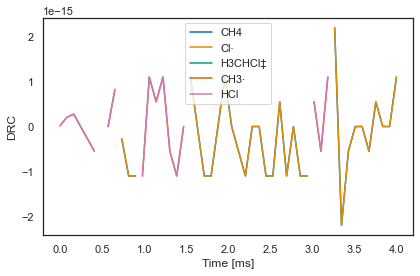

In [9]:
t = np.linspace(0, 0.004)

fig, ax = plt.subplots()
for i, name in enumerate(model.scheme.compounds):
    # if not api.is_transition_state(name):
    ax.plot(1e3 * t, drc(t)[i], label=f"{name}")

ax.set_ylabel("DRC")
ax.set_xlabel("Time [ms]")

ax.legend()
fig.tight_layout()